In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mpl_finance

In [ ]:
!pip install ta

In [4]:
from mpl_finance import candlestick_ohlc
import matplotlib.pyplot as plt
import mpl_finance as mpf
import numpy as np
import pandas as pd
from matplotlib.pylab import date2num

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MMTC/Сбербанк.txt', sep=';', parse_dates= ["<DATE>"])[["<DATE>","<OPEN>",'<HIGH>','<LOW>','<CLOSE>','<VOL>']]
df['<DATE_1>'] =df['<DATE>'].apply(lambda x:date2num(x))

Text(0.5, 0, 'time')

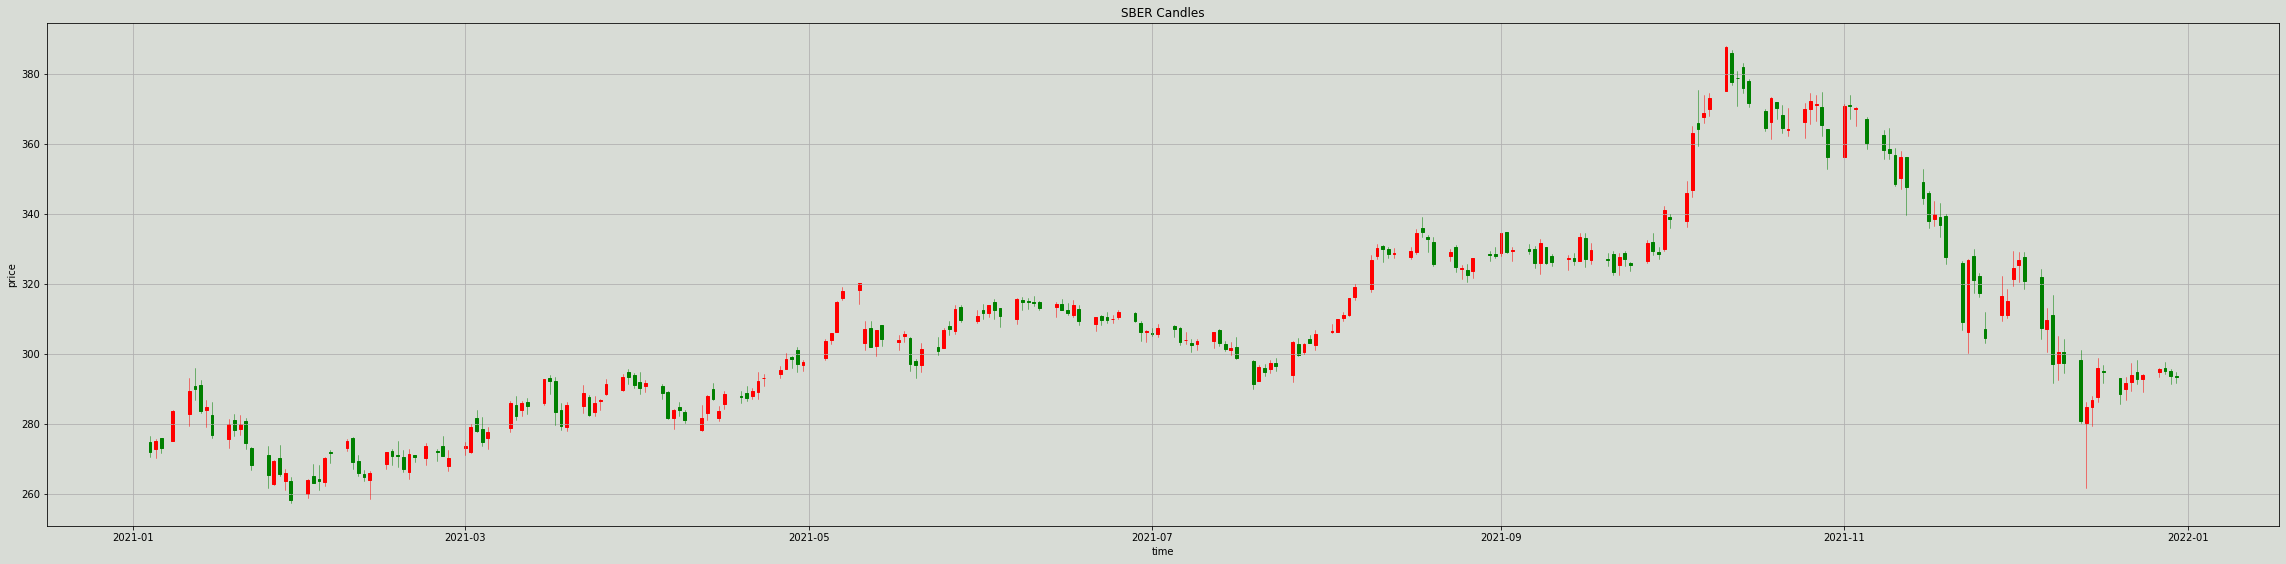

In [6]:
plt.figure(figsize = (40, 15), facecolor = '#d8dcd6')
ax = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)

candlestick_ohlc(ax,np.array(df[["<DATE_1>",	"<OPEN>",	"<HIGH>",	"<LOW>",	"<CLOSE>"]]),width=0.5,colorup='r',colordown='green') 

ax.set_title('SBER Candles')
ax.xaxis_date()
ax.set_ylabel('price')
ax.grid(True)
ax.set_facecolor('#d8dcd6')
ax.set_xlabel('time')

In [7]:
df["<VOL>"] = pd.to_numeric(df["<VOL>"], errors='coerce')
df["<VOL>"] = df["<VOL>"].fillna(0)

In [8]:
from ta import add_all_ta_features
import ta
df = add_all_ta_features(df, open="<OPEN>", high="<HIGH>", low="<LOW>", close="<CLOSE>", volume="<VOL>", fillna=True)

/usr/local/lib/python3.7/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.7/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


# Parabolic SAR

In [9]:
from ta.trend import PSARIndicator
Psar = PSARIndicator(high = df["<HIGH>"], low = df["<LOW>"], close = df["<CLOSE>"], step = 0.02, max_step = 0.2)
df["PSARu"] = Psar.psar_up()
df["PSARd"] = Psar.psar_down()

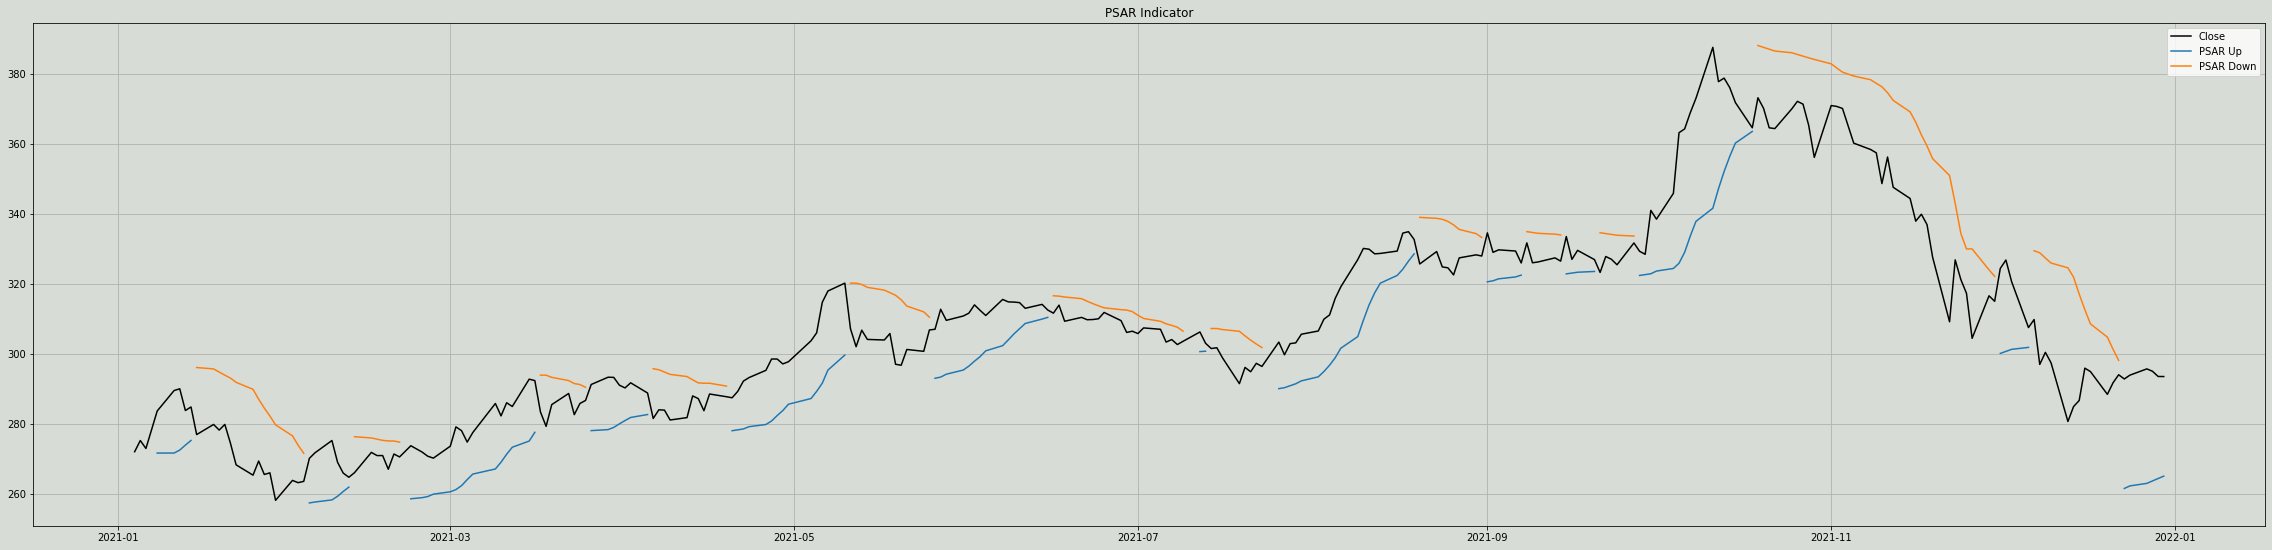

In [11]:
plt.figure(figsize = (40, 15), facecolor = '#d8dcd6')
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)

ax1.plot(df['<DATE>'],df['<CLOSE>'], label = 'Close', color = 'black')
ax1.plot(df['<DATE>'],df['PSARu'], label = 'PSAR Up')
ax1.plot(df['<DATE>'],df['PSARd'], label = 'PSAR Down')

ax1.set_title('PSAR Indicator')
ax1.legend(loc = 'best')
ax1.grid(True)
ax1.set_facecolor('#d8dcd6')

# RSI

In [12]:
from ta.momentum import RSIIndicator
df["RSI"] = RSIIndicator(df['<CLOSE>'], 10).rsi()

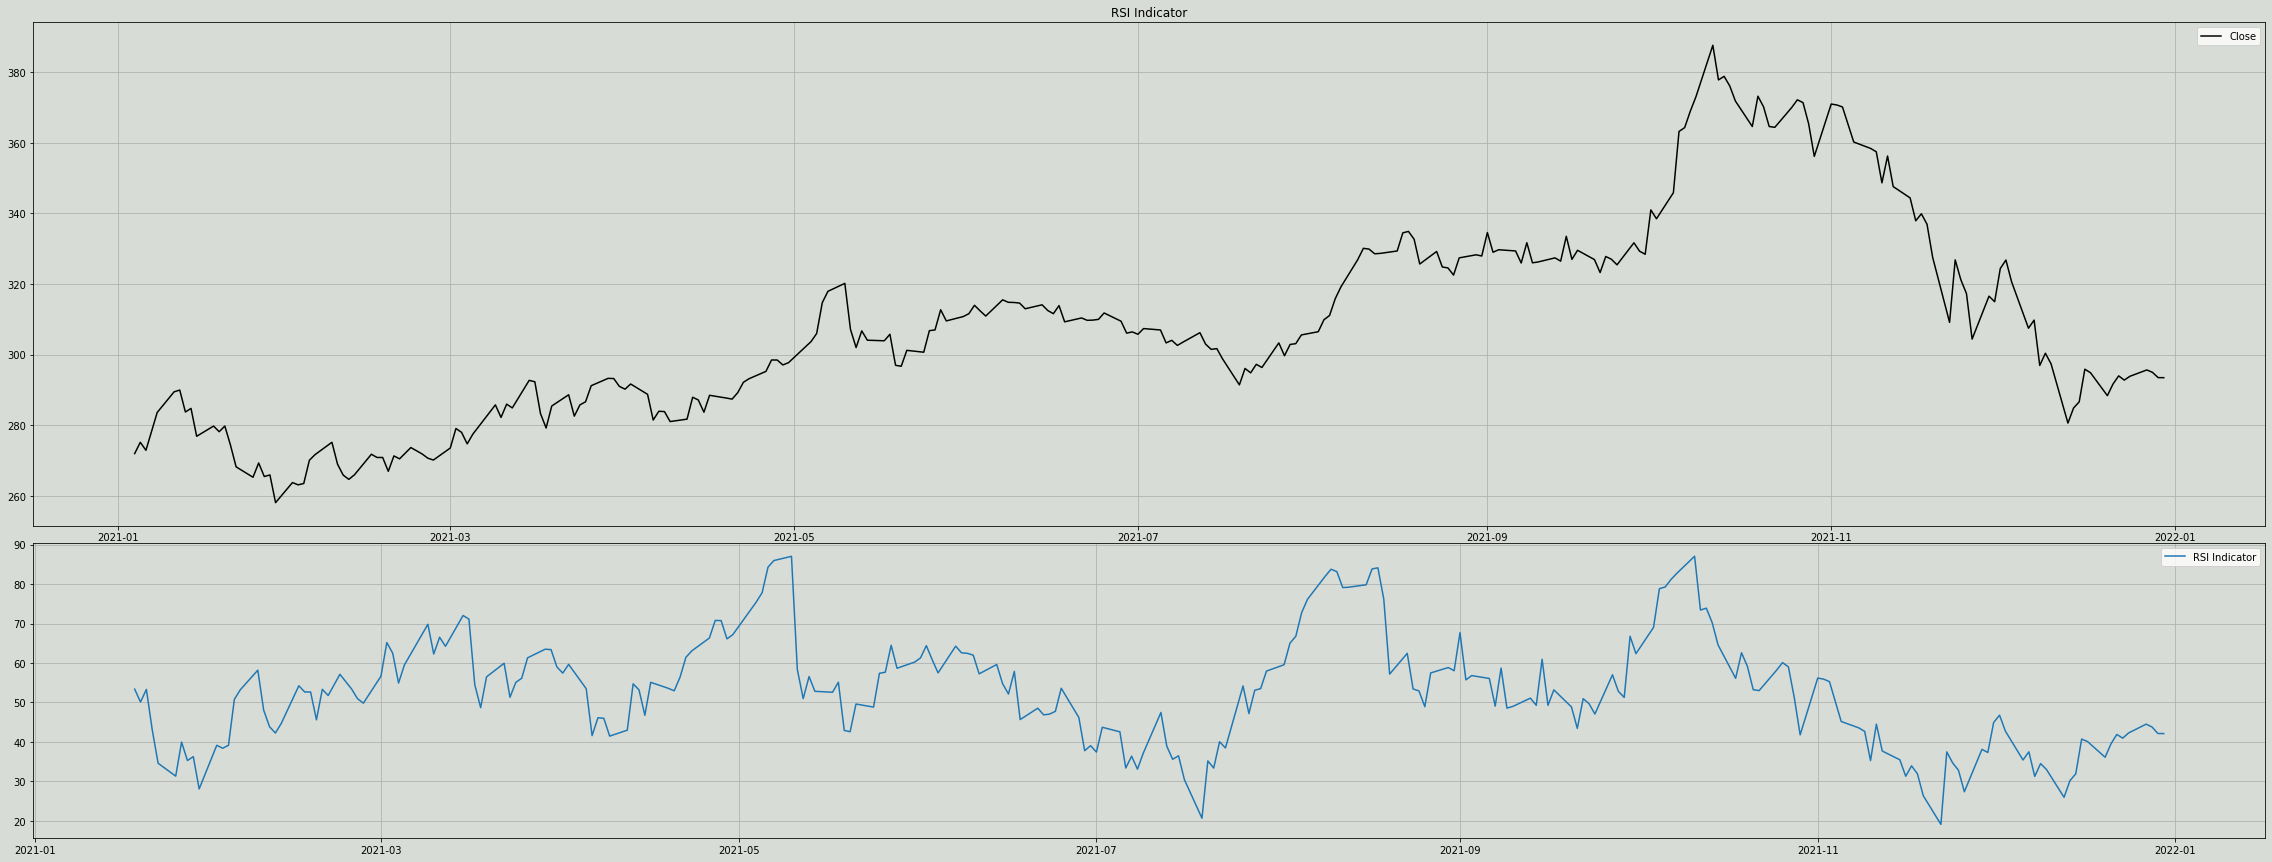

In [15]:
plt.figure(figsize = (40, 15), facecolor = '#d8dcd6')
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(df['<DATE>'],df['<CLOSE>'], label = 'Close', color = 'black')
ax2.plot(df['<DATE>'],df['RSI'], label = 'RSI Indicator')

ax1.set_title('RSI Indicator')
ax1.legend(loc = 'best')
ax2.legend(loc = 'best')

ax1.grid(True)
ax2.grid(True)

ax1.set_facecolor('#d8dcd6')
ax2.set_facecolor('#d8dcd6')

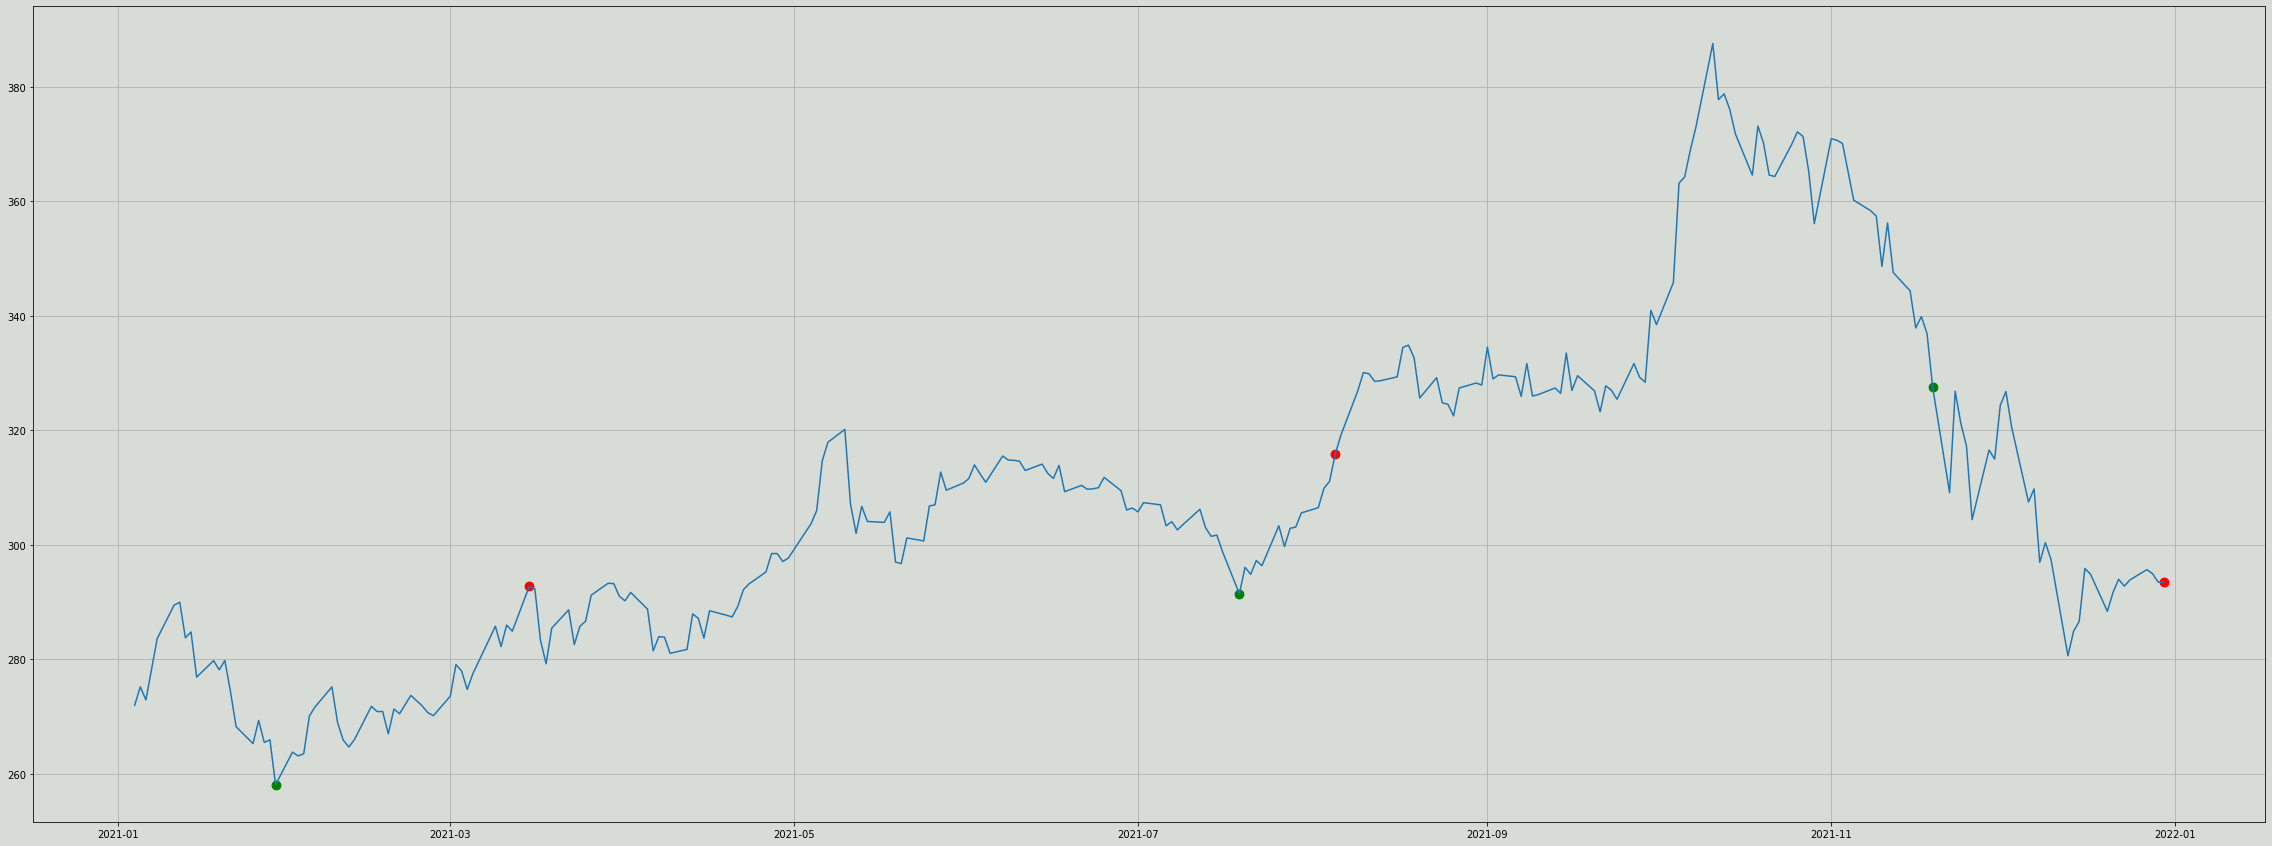

In [17]:
RSIdf = pd.DataFrame(df[['<DATE>', '<CLOSE>']])
balance = 100000
price = 0 
count = 0
# k = 0
balance_df, count_df, price_df, day_status = [], [], [], []
fig,ax=plt.subplots(facecolor="#d8dcd6",figsize=(40,15))
plt.plot(df['<DATE>'],df["<CLOSE>"])

for i in  range(len(df)):
  price = 0
  if ((balance >= df['<CLOSE>'][i]) and (df["RSI"][i]<30 and df["RSI"][i-1]>30)): 
    count += balance // df['<CLOSE>'][i]
    price = df['<CLOSE>'][i] * count
    balance = balance - price
    #k += price * 0.01
    day_status.append('buy')
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='green', s=78)
  
  elif count > 0 and (df["RSI"][i]>70):
    balance += count * df['<CLOSE>'][i]
    #k += count * df['<CLOSE>'][i] * 0.01
    count = 0
    price = df['<CLOSE>'][i]
    day_status.append('sell')
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='red', s=78)

  elif i == (len(df)-1) and count>0:
    balance += count * df['<CLOSE>'][i]
    #k += count * df['<CLOSE>'][i] * 0.01
    count = 0
    price = df['<CLOSE>'][i]
    day_status.append('sell')
    #print(f'Комиссия за всё время: {k}')
    #balance -= k
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='red', s=78)
  else:
    day_status.append('nothing')
  
  count_df.append(count)
  balance_df.append(balance)
  price_df.append(price)

ax.set_facecolor('#d8dcd6')
ax.grid(True)

RSIdf["NumOfShares"] = count_df
RSIdf["MoneySpent"] = price_df
RSIdf["Balance"] = balance_df
RSIdf["DayStatus"] = day_status

In [18]:
RSIdf[(RSIdf['DayStatus'] == 'buy') | (RSIdf['DayStatus'] == 'sell')]

,<DATE>,<CLOSE>,NumOfShares,MoneySpent,Balance,DayStatus
18,2021-01-29,258.11,387.0,99888.57,111.43,buy
48,2021-03-15,292.74,0.0,292.74,113401.81,sell
137,2021-07-19,291.46,389.0,113377.94,23.87,buy
150,2021-08-05,315.82,0.0,315.82,122877.85,sell
225,2021-11-19,327.56,375.0,122835.00,42.85,buy
254,2021-12-30,293.49,0.0,293.49,110101.60,sell


#Stochastic

In [ ]:
from ta.momentum import StochasticOscillator
df["Stoch"] = StochasticOscillator(high = df["<HIGH>"], low = df["<LOW>"], close = df["<CLOSE>"])